In [1]:
!python --version

Python 3.12.0


In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import MACD, ADXIndicator
from ta.volatility import AverageTrueRange, BollingerBands
from ta.volume import OnBalanceVolumeIndicator
from sklearn.preprocessing import StandardScaler
import pickle
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:


def clean_price_column(col):
    """
    Clean a price column by removing '$' and converting to float.
    
    Args:
        col (pd.Series): Column to clean
    
    Returns:
        pd.Series: Cleaned numeric column
    """
    return col.str.replace('$', '', regex=False).astype(float)

def process_stock_data(df):
    """
    Process a single stock's data to create sequences and targets.
    
    Args:
        df (pd.DataFrame): Stock data with columns ['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low']
    
    Returns:
        tuple: (sequences, y, dates)
            - sequences: List of arrays with shape [timesteps, num_features]
            - y: List of percent changes (clipped to [-8, 8])
            - dates: List of dates for the last day in each sequence
    """
    # Clean and convert price columns to numeric
    price_cols = ['Close/Last', 'Open', 'High', 'Low']
    for col in price_cols:
        df[col] = clean_price_column(df[col])
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    
    # Take from row 29 (30th oldest, 0-based index) to end
    df = df.iloc[29:].copy()
    
    # Check if sufficient data is available for MACD (26 periods)
    if len(df) < 26:
        print(f"Insufficient data for stock: {len(df)} rows. Skipping.")
        return [], [], []
    
    # Calculate technical indicators
    df['RSI_7'] = RSIIndicator(df['Close/Last'], window=7).rsi()
    macd = MACD(df['Close/Last'], window_slow=26, window_fast=12)
    df['MACD'] = macd.macd()
    adx_window = min(14, len(df) - 1)
    adx = ADXIndicator(df['High'], df['Low'], df['Close/Last'], window=adx_window)
    df['ADX_14'] = adx.adx()
    atr = AverageTrueRange(df['High'], df['Low'], df['Close/Last'], window=14)
    df['ATR_14'] = atr.average_true_range()
    obv = OnBalanceVolumeIndicator(df['Close/Last'], df['Volume'])
    df['OBV'] = obv.on_balance_volume()
    bb = BollingerBands(df['Close/Last'], window=20)
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    
    # Drop rows with NaN indicators
    df = df.dropna().reset_index(drop=True)
    
    # Skip another 20 rows if possible
    if len(df) < 20:
        print(f"Insufficient data after dropping NaNs: {len(df)} rows. Skipping stock.")
        return [], [], []
    df = df.iloc[20:].copy().reset_index(drop=True)
    
    # Define features
    features = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'RSI_7', 'MACD', 'ADX_14', 'ATR_14', 'OBV', 'BB_upper', 'BB_lower']
    num_features = len(features)
    rsi_index = features.index('RSI_7')
    
    # Create sequences
    sequences = []
    y = []
    dates = []
    for i in range(len(df) - 20):
        seq = df.iloc[i:i+20]
        seq_features = seq[features].values  # Shape: [timesteps, num_features]
        # Scale features except RSI_7 within the sequence
        scaler = StandardScaler()
        seq_scaled = scaler.fit_transform(seq_features)
        seq_scaled[:, rsi_index] = seq_features[:, rsi_index]  # Preserve RSI_7
        # Keep shape as [timesteps, num_features]
        sequences.append(seq_scaled)
        
        # Calculate y: percent change
        today_close = df.iloc[i+19]['Close/Last']
        tomorrow_close = df.iloc[i+20]['Close/Last']
        percent_change = 100 * (tomorrow_close - today_close) / today_close
        # Clip percent change to [-8, 8]
        percent_change = np.clip(percent_change, -8, 8)
        y.append(percent_change)
        
        # Store date of the last day in the sequence
        dates.append(df.iloc[i+19]['Date'])
    
    return sequences, y, dates

def load_and_process_stock_data():
    """
    Load and process stock data for multiple companies, aggregating sequences and targets.
    
    Returns:
        tuple: (X, y)
            - X: Array of shape [num_sequences, timesteps, num_features]
            - y: Array of shape [num_sequences], scaled with StandardScaler
    
    Saves:
        x_and_y.pkl: Pickle file containing (X, y)
        target_scaler.pkl: Pickle file containing the StandardScaler for y
    """
    stock_files = [
        "amzn_data.csv", "nflx_data.csv", "tsla_data.csv", "aapl_data.csv",
        "qcom_data.csv", "msft_data.csv", "sbux_data.csv", "csco_data.csv", "meta_data.csv"
    ]
    all_data = []
    
    for stock_file in stock_files:
        file_path = "./rawData/"+stock_file
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        sequences, y, dates = process_stock_data(df)
        if sequences:
            for seq, yy, dd in zip(sequences, y, dates):
                all_data.append((seq, yy, dd))
        else:
            print(f"No sequences generated for {stock_file}")
    
    if not all_data:
        raise ValueError("No valid sequences generated from any stock data.")
    
    # Sort by date to maintain temporal order
    all_data.sort(key=lambda x: x[2])
    
    # Extract X and y
    X = np.array([item[0] for item in all_data])  # Shape: [num_sequences, timesteps, num_features]
    y = np.array([item[1] for item in all_data])  # Shape: [num_sequences]
    
    # Scale the target values
    target_scaler = StandardScaler()
    y = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape for scaler, then flatten back
    
    # Save X, y, and target scaler
    with open("x_and_y.pkl", "wb") as f:
        pickle.dump((X, y), f)
    with open("target_scaler.pkl", "wb") as f:
        pickle.dump(target_scaler, f)
    
    return X, y


In [3]:
X,y = load_and_process_stock_data()

Insufficient data for stock: 0 rows. Skipping.
No sequences generated for qcom_data.csv


In [ ]:
X.shape,y.shape

In [ ]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)  # For NumPy (used by scikit-learn)
torch.manual_seed(SEED)  # For PyTorch
torch.cuda.manual_seed_all(SEED)  # For CUDA (if using GPU)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
# Split data with reproducible shuffling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=SEED)

def make_loader(X, y, bs=32, shuffle=False):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32).to(device),
                       torch.tensor(y, dtype=torch.float32).to(device))
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

# Create data loaders
train_loader = make_loader(X_train, y_train, shuffle=True)
val_loader = make_loader(X_val, y_val)
test_loader = make_loader(X_test, y_test)

In [104]:

# Collect all target values from test_loader
all_targets = []
for _, targets in test_loader:
    all_targets.append(targets.cpu().numpy())
all_targets = np.concatenate(all_targets)

# Compute statistics
mean = np.mean(all_targets)
median = np.median(all_targets)
std = np.std(all_targets)
min_val = np.min(all_targets)
max_val = np.max(all_targets)
num_values = len(all_targets)

# Print results
print("Test DataLoader Target Statistics:")
print(f"Number of Values: {num_values}")
print(f"Mean: {mean:.6f}")
print(f"Median: {median:.6f}")
print(f"Standard Deviation: {std:.6f}")
print(f"Minimum: {min_val:.6f}")
print(f"Maximum: {max_val:.6f}")

Test DataLoader Target Statistics:
Number of Values: 2907
Mean: -0.004569
Median: -0.000535
Standard Deviation: 0.956245
Minimum: -3.819506
Maximum: 3.733095


In [106]:
# Define LSTM_Linear model
class LSTM_Linear(nn.Module):
    """
    LSTM model with a linear output layer.
    
    Args:
        input_size: Number of input features
        hidden_size: Number of hidden units
        output_size: Number of output units
        num_layers: Number of LSTM layers
        dropout_rate: Dropout probability
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3):
        super(LSTM_Linear, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0).to(device)
        self.dropout = nn.Dropout(dropout_rate).to(device)
        self.linear = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.linear(out)
        return out

# Define LSTM_NdLinear model with multi-dimensional hidden layers
class LSTM_NdLinear(nn.Module):
    """
    LSTM model with an NdLinear output layer.
    
    Args:
        input_size: Number of input features
        hidden_size: Number of hidden units
        output_size: Number of output units
        nd_hidden: Hidden dimensions for NdLinear
        num_layers: Number of LSTM layers
        dropout_rate: Dropout probability
    """
    def __init__(self, input_size, hidden_size, output_size, nd_hidden=(64, 32), num_layers=2, dropout_rate=0.3):
        super(LSTM_NdLinear, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0).to(device)
        self.dropout = nn.Dropout(dropout_rate).to(device)
        self.ndlinear = NdLinear(input_dims=(hidden_size, 1), hidden_size=nd_hidden).to(device)
        self.linear = nn.Linear(np.prod(nd_hidden), output_size).to(device)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :].unsqueeze(-1)
        nd_out = self.ndlinear(last_out)
        nd_out = self.dropout(nd_out.view(nd_out.size(0), -1))
        out = self.linear(nd_out)
        return out

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=50):
    """
    Train and evaluate a model with MSE loss.
    
    Args:
        model: Model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        criterion: Loss function (MSELoss)
        optimizer: Optimizer
        epochs: Number of training epochs
    
    Returns:
        Tuple of (train_losses, val_losses, test_loss)
    """
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    return train_losses, val_losses, test_loss

# Initialize models
input_size = 12  # Number of features
hidden_size = 128
output_size = 1
nd_hidden = (64, 32)  # Multi-dimensional hidden layer for NdLinear

lstm_linear = LSTM_Linear(input_size, hidden_size, output_size).to(device)
lstm_ndlinear = LSTM_NdLinear(input_size, hidden_size, output_size, nd_hidden).to(device)

# Define loss and optimizers
criterion = nn.MSELoss().to(device)
optimizer_lstm_linear = optim.Adam(lstm_linear.parameters(), lr=0.001)
optimizer_lstm_ndlinear = optim.Adam(lstm_ndlinear.parameters(), lr=0.001)

# Train and evaluate LSTM_Linear
print("Training LSTM_Linear...")
train_losses_lstm_linear, val_losses_lstm_linear, test_floss_lstm_linear = train_and_evaluate(
    lstm_linear, train_loader, val_loader, test_loader, criterion, optimizer_lstm_linear
)

# Train and evaluate LSTM_NdLinear
print("Training LSTM_NdLinear...")
train_losses_lstm_ndlinear, val_losses_lstm_ndlinear, test_loss_lstm_ndlinear = train_and_evaluate(
    lstm_ndlinear, train_loader, val_loader, test_loader, criterion, optimizer_lstm_ndlinear
)

Training LSTM_Linear...
Epoch 1, Train Loss: 1.0103, Val Loss: 1.0573
Epoch 2, Train Loss: 1.0074, Val Loss: 1.0570
Epoch 3, Train Loss: 1.0069, Val Loss: 1.0605
Epoch 4, Train Loss: 1.0065, Val Loss: 1.0585
Epoch 5, Train Loss: 1.0067, Val Loss: 1.0576
Epoch 6, Train Loss: 1.0064, Val Loss: 1.0573
Epoch 7, Train Loss: 1.0055, Val Loss: 1.0575
Epoch 8, Train Loss: 1.0059, Val Loss: 1.0572
Epoch 9, Train Loss: 1.0045, Val Loss: 1.0587
Epoch 10, Train Loss: 1.0041, Val Loss: 1.0569
Epoch 11, Train Loss: 1.0041, Val Loss: 1.0595
Epoch 12, Train Loss: 1.0042, Val Loss: 1.0562
Epoch 13, Train Loss: 1.0033, Val Loss: 1.0578
Epoch 14, Train Loss: 1.0021, Val Loss: 1.0585
Epoch 15, Train Loss: 1.0012, Val Loss: 1.0573
Epoch 16, Train Loss: 1.0000, Val Loss: 1.0573
Epoch 17, Train Loss: 0.9978, Val Loss: 1.0611
Epoch 18, Train Loss: 0.9985, Val Loss: 1.0598
Epoch 19, Train Loss: 0.9940, Val Loss: 1.0648
Epoch 20, Train Loss: 0.9907, Val Loss: 1.0658
Epoch 21, Train Loss: 0.9915, Val Loss: 1.076

In [108]:
# Define RNN_Linear model
class RNN_Linear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3):
        super(RNN_Linear, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0).to(device)
        self.dropout = nn.Dropout(dropout_rate).to(device)
        self.linear = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = self.dropout(rnn_out[:, -1, :])
        out = self.linear(out)
        return out

# Define RNN_NdLinear model with multi-dimensional hidden layers
class RNN_NdLinear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nd_hidden=(64, 32), num_layers=2, dropout_rate=0.3):
        super(RNN_NdLinear, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0).to(device)
        self.dropout = nn.Dropout(dropout_rate).to(device)
        self.ndlinear = NdLinear(input_dims=(hidden_size, 1), hidden_size=nd_hidden).to(device)
        self.linear = nn.Linear(np.prod(nd_hidden), output_size).to(device)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_out = rnn_out[:, -1, :].unsqueeze(-1)
        nd_out = self.ndlinear(last_out)
        nd_out = self.dropout(nd_out.view(nd_out.size(0), -1))
        out = self.linear(nd_out)
        return out

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    return train_losses, val_losses, test_loss

# Initialize models
input_size = 12  # Number of features
hidden_size = 128
output_size = 1
nd_hidden = (64, 32)  # Multi-dimensional hidden layer for NdLinear

rnn_linear = RNN_Linear(input_size, hidden_size, output_size).to(device)
rnn_ndlinear = RNN_NdLinear(input_size, hidden_size, output_size, nd_hidden).to(device)

# Define loss and optimizers
criterion = nn.MSELoss().to(device)
optimizer_rnn_linear = optim.Adam(rnn_linear.parameters(), lr=0.001)
optimizer_rnn_ndlinear = optim.Adam(rnn_ndlinear.parameters(), lr=0.001)

# Train and evaluate RNN_Linear
print("Training RNN_Linear...")
train_losses_rnn_linear, val_losses_rnn_linear, test_loss_rnn_linear = train_and_evaluate(
    rnn_linear, train_loader, val_loader, test_loader, criterion, optimizer_rnn_linear
)

# Train and evaluate RNN_NdLinear
print("Training RNN_NdLinear...")
train_losses_rnn_ndlinear, val_losses_rnn_ndlinear, test_loss_rnn_ndlinear = train_and_evaluate(
    rnn_ndlinear, train_loader, val_loader, test_loader, criterion, optimizer_rnn_ndlinear
)

Training RNN_Linear...
Epoch 1, Train Loss: 1.0544, Val Loss: 1.0617
Epoch 2, Train Loss: 1.0223, Val Loss: 1.0579
Epoch 3, Train Loss: 1.0149, Val Loss: 1.0592
Epoch 4, Train Loss: 1.0140, Val Loss: 1.0561
Epoch 5, Train Loss: 1.0123, Val Loss: 1.0631
Epoch 6, Train Loss: 1.0124, Val Loss: 1.0558
Epoch 7, Train Loss: 1.0146, Val Loss: 1.0595
Epoch 8, Train Loss: 1.0145, Val Loss: 1.0670
Epoch 9, Train Loss: 1.0156, Val Loss: 1.0598
Epoch 10, Train Loss: 1.0159, Val Loss: 1.0596
Epoch 11, Train Loss: 1.0156, Val Loss: 1.0742
Epoch 12, Train Loss: 1.0132, Val Loss: 1.0570
Epoch 13, Train Loss: 1.0176, Val Loss: 1.0625
Epoch 14, Train Loss: 1.0156, Val Loss: 1.1226
Epoch 15, Train Loss: 1.0162, Val Loss: 1.0563
Epoch 16, Train Loss: 1.0185, Val Loss: 1.0860
Epoch 17, Train Loss: 1.0164, Val Loss: 1.0558
Epoch 18, Train Loss: 1.0155, Val Loss: 1.0558
Epoch 19, Train Loss: 1.0161, Val Loss: 1.0570
Epoch 20, Train Loss: 1.0179, Val Loss: 1.1005
Epoch 21, Train Loss: 1.0153, Val Loss: 1.0747

In [109]:
# Define TCN block
class TCN(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size=3):
        super(TCN, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(input_size, hidden_size, kernel_size=kernel_size, padding=padding).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x):
        x = x.transpose(1, 2)  # [batch, features, timesteps]
        out = self.conv(x)
        out = self.relu(out)
        out = out.transpose(1, 2)  # [batch, timesteps, hidden_size]
        return out

# Define TCN_Linear model
class TCN_Linear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(TCN_Linear, self).__init__()
        self.tcn = TCN(input_size, hidden_size).to(device)
        self.dropout = nn.Dropout(dropout_rate).to(device)
        self.linear = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, x):
        tcn_out = self.tcn(x)
        out = self.dropout(tcn_out[:, -1, :])
        out = self.linear(out)
        return out

# Define TCN_NdLinear model with multi-dimensional hidden layers
class TCN_NdLinear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nd_hidden=(64, 32), dropout_rate=0.3):
        super(TCN_NdLinear, self).__init__()
        self.tcn = TCN(input_size, hidden_size).to(device)
        self.dropout = nn.Dropout(dropout_rate).to(device)
        self.ndlinear = NdLinear(input_dims=(hidden_size, 1), hidden_size=nd_hidden).to(device)
        self.linear = nn.Linear(np.prod(nd_hidden), output_size).to(device)

    def forward(self, x):
        tcn_out = self.tcn(x)
        last_out = tcn_out[:, -1, :].unsqueeze(-1)
        nd_out = self.ndlinear(last_out)
        nd_out = self.dropout(nd_out.view(nd_out.size(0), -1))
        out = self.linear(nd_out)
        return out

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    return train_losses, val_losses, test_loss

# Initialize models
input_size = 12  # Number of features
hidden_size = 128
output_size = 1
nd_hidden = (64, 32)  # Multi-dimensional hidden layer for NdLinear

tcn_linear = TCN_Linear(input_size, hidden_size, output_size).to(device)
tcn_ndlinear = TCN_NdLinear(input_size, hidden_size, output_size, nd_hidden).to(device)

# Define loss and optimizers
criterion = nn.MSELoss().to(device)
optimizer_tcn_linear = optim.Adam(tcn_linear.parameters(), lr=0.001)
optimizer_tcn_ndlinear = optim.Adam(tcn_ndlinear.parameters(), lr=0.001)

# Train and evaluate TCN_Linear
print("Training TCN_Linear...")
train_losses_tcn_linear, val_losses_tcn_linear, test_loss_tcn_linear = train_and_evaluate(
    tcn_linear, train_loader, val_loader, test_loader, criterion, optimizer_tcn_linear
)

# Train and evaluate TCN_NdLinear
print("Training TCN_NdLinear...")
train_losses_tcn_ndlinear, val_losses_tcn_ndlinear, test_loss_tcn_ndlinear = train_and_evaluate(
    tcn_ndlinear, train_loader, val_loader, test_loader, criterion, optimizer_tcn_ndlinear
)

Training TCN_Linear...
Epoch 1, Train Loss: 2.6110, Val Loss: 1.0969
Epoch 2, Train Loss: 1.0467, Val Loss: 1.0611
Epoch 3, Train Loss: 1.0200, Val Loss: 1.0723
Epoch 4, Train Loss: 1.0206, Val Loss: 1.0596
Epoch 5, Train Loss: 1.0171, Val Loss: 1.0590
Epoch 6, Train Loss: 1.0186, Val Loss: 1.0613
Epoch 7, Train Loss: 1.0125, Val Loss: 1.0633
Epoch 8, Train Loss: 1.0107, Val Loss: 1.0670
Epoch 9, Train Loss: 1.0094, Val Loss: 1.0617
Epoch 10, Train Loss: 1.0055, Val Loss: 1.0638
Epoch 11, Train Loss: 1.0067, Val Loss: 1.0583
Epoch 12, Train Loss: 1.0044, Val Loss: 1.0590
Epoch 13, Train Loss: 1.0016, Val Loss: 1.0592
Epoch 14, Train Loss: 1.0016, Val Loss: 1.0598
Epoch 15, Train Loss: 1.0013, Val Loss: 1.0580
Epoch 16, Train Loss: 0.9994, Val Loss: 1.0591
Epoch 17, Train Loss: 1.0002, Val Loss: 1.0591
Epoch 18, Train Loss: 0.9995, Val Loss: 1.0590
Epoch 19, Train Loss: 0.9988, Val Loss: 1.0601
Epoch 20, Train Loss: 0.9984, Val Loss: 1.0636
Epoch 21, Train Loss: 0.9992, Val Loss: 1.0626

In [110]:
torch.save(lstm_linear,"lstm_linear.pth")
torch.save(lstm_ndlinear,"lstm_ndlinear.pth")
torch.save(rnn_linear,"rnn_linear.pth")
torch.save(rnn_ndlinear,"rnn_ndlinear.pth")
torch.save(tcn_linear,"tcn_linear.pth")
torch.save(tcn_ndlinear,"tcn_ndlinear.pth")


In [112]:
# NdLinear-based Model
class NdFeedForward(nn.Module):
    """
    NdLinear-based feedforward network for transformer, adapted from ts_forecast.py.
    
    Args:
        input_dim: Input dimension
        hidden_dim: Multi-dimensional hidden size for NdLinear (e.g., (256, 1))
        dropout: Dropout rate
        activation: Activation function
    """
    def __init__(self, input_dim, hidden_dim=(128, 128), dropout=0.1, activation='gelu'):
        super(NdFeedForward, self).__init__()
        activations = {
            'relu': nn.ReLU().to(device),
            'tanh': nn.Tanh().to(device),
            'sigmoid': nn.Sigmoid().to(device),
            'gelu': nn.GELU().to(device),
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        self.layer1 = NdLinear((input_dim, 1), hidden_dim).to(device)
        self.activation = activations[activation]
        self.dropout = nn.Dropout(dropout).to(device)
        self.layer2 = NdLinear(hidden_dim, (input_dim, 1)).to(device)

    def forward(self, x):
        x_dims = list(x.shape)
        x = x.reshape(x_dims[0] * x_dims[1], x_dims[2], 1)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = x.reshape(x_dims[0], x_dims[1], x_dims[2])
        return x

class NdTransformerEncoderLayer(nn.TransformerEncoderLayer):
    """
    Transformer encoder layer with NdLinear feedforward, adapted from ts_forecast.py.
    
    Args:
        d_model: Model dimension
        nhead: Number of attention heads
        custom_ffn: NdFeedForward instance
    """
    def __init__(self, d_model, nhead, custom_ffn, **kwargs):
        kwargs['batch_first'] = True
        super(NdTransformerEncoderLayer, self).__init__(d_model, nhead, **kwargs)
        self.nd_ffn = custom_ffn.to(device)

    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.nd_ffn(x)
        return x

class Transformer_NdLinear(nn.Module):
    """
    Transformer model with NdLinear feedforward for stock price prediction.
    
    Args:
        input_dim: Number of input features (12)
        model_dim: Transformer model dimension
        num_heads: Number of attention heads
        num_layers: Number of transformer layers
        hidden_dim: Hidden dimension for NdFeedForward
        dropout: Dropout rate
        activation: Activation function
    """
    def __init__(self, input_dim, model_dim=64, num_heads=2, num_layers=3, hidden_dim=(128, 128), dropout=0.1, activation='gelu'):
        super(Transformer_NdLinear, self).__init__()
        ff_layer = NdFeedForward(model_dim, hidden_dim=hidden_dim, dropout=dropout, activation=activation).to(device)
        encoder_layer = NdTransformerEncoderLayer(model_dim, num_heads, custom_ffn=ff_layer, dropout=dropout).to(device)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
        self.embedding = nn.Linear(input_dim, model_dim).to(device)
        self.fc_out = nn.Linear(model_dim, 1).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]  # Take the last timestep
        output = self.dropout(output)
        output = self.fc_out(output)
        return output

# Standard Linear-based Model
class LinearFeedForward(nn.Module):
    """
    Standard feedforward network with Linear layers.
    
    Args:
        input_dim: Input dimension
        hidden_dim: Hidden dimension for Linear layers
        dropout: Dropout rate
        activation: Activation function
    """
    def __init__(self, input_dim, hidden_dim=256, dropout=0.1, activation='gelu'):
        super(LinearFeedForward, self).__init__()
        activations = {
            'relu': nn.ReLU().to(device),
            'tanh': nn.Tanh().to(device),
            'sigmoid': nn.Sigmoid().to(device),
            'gelu': nn.GELU().to(device),
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        self.layer1 = nn.Linear(input_dim, hidden_dim).to(device)
        self.activation = activations[activation]
        self.dropout = nn.Dropout(dropout).to(device)
        self.layer2 = nn.Linear(hidden_dim, input_dim).to(device)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

class Transformer_Linear(nn.Module):
    """
    Transformer model with standard Linear feedforward for stock price prediction.
    
    Args:
        input_dim: Number of input features (12)
        model_dim: Transformer model dimension
        num_heads: Number of attention heads
        num_layers: Number of transformer layers
        hidden_dim: Hidden dimension for FeedForward
        dropout: Dropout rate
        activation: Activation function
    """
    def __init__(self, input_dim, model_dim=64, num_heads=2, num_layers=3, hidden_dim=256, dropout=0.1, activation='gelu'):
        super(Transformer_Linear, self).__init__()
        ff_layer = LinearFeedForward(model_dim, hidden_dim=hidden_dim, dropout=dropout, activation=activation).to(device)
        encoder_layer = nn.TransformerEncoderLayer(model_dim, num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True).to(device)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
        self.embedding = nn.Linear(input_dim, model_dim).to(device)
        self.fc_out = nn.Linear(model_dim, 1).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]  # Take the last timestep
        output = self.dropout(output)
        output = self.fc_out(output)
        return output

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=50, model_name="Model"):
    """
    Train and evaluate the model with MSE loss and mixed precision.
    
    Args:
        model: Transformer model (NdLinear or Linear)
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        criterion: Loss function (MSELoss)
        optimizer: Optimizer
        epochs: Number of training epochs
        model_name: Name of the model for logging
    
    Returns:
        Tuple of (train_losses, val_losses, test_loss)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    scaler = torch.cuda.amp.GradScaler()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f'Training {model_name} Epoch {epoch+1}/{epochs}', leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        val_outputs = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()
                val_outputs.append(outputs.squeeze().cpu().numpy())
            val_loss /= len(val_loader)
            val_outputs = np.concatenate(val_outputs)
            output_std = np.std(val_outputs)
            print(f"{model_name} Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Val Output Std: {output_std:.6f}, Min Val Pred: {val_outputs.min():.6f}, Max Val Pred: {val_outputs.max():.6f}")
        
        val_losses.append(val_loss)
    
    model.eval()
    test_loss = 0
    test_outputs = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
            test_outputs.append(outputs.squeeze().cpu().numpy())
            test_targets.append(targets.cpu().numpy())
        test_loss /= len(test_loader)
        test_outputs = np.concatenate(test_outputs)
        test_targets = np.concatenate(test_targets)
        print(f"{model_name} Test Loss: {test_loss:.4f}")
        print(f"{model_name} Test Outputs: Min: {test_outputs.min():.6f}, Max: {test_outputs.max():.6f}, Std: {np.std(test_outputs):.6f}")
        print(f"{model_name} Test Targets: Min: {test_targets.min():.6f}, Max: {test_targets.max():.6f}, Std: {np.std(test_targets):.6f}")
    
    return train_losses, val_losses, test_loss

# Initialize and train NdLinear model
input_dim = 12  # Number of features
model_ndlinear = Transformer_NdLinear(input_dim, model_dim=64, num_heads=2, num_layers=3, hidden_dim=(128,128), dropout=0.1, activation='gelu').to(device)
optimizer_ndlinear = optim.Adam(model_ndlinear.parameters(), lr=0.0001)
criterion = nn.MSELoss().to(device)
print("Training Transformer_NdLinear...")
train_losses_ndlinear, val_losses_ndlinear, test_loss_ndlinear = train_and_evaluate(
    model_ndlinear, train_loader, val_loader, test_loader, criterion, optimizer_ndlinear, epochs=50, model_name="Transformer_NdLinear"
)

# Save NdLinear model
torch.save(model_ndlinear.state_dict(), 'transformer_ndlinear.pth')

# Initialize and train Linear model
model_linear = Transformer_Linear(input_dim, model_dim=64, num_heads=2, num_layers=3, hidden_dim=256, dropout=0.1, activation='gelu').to(device)
optimizer_linear = optim.Adam(model_linear.parameters(), lr=0.0001)
print("Training Transformer_Linear...")
train_losses_linear, val_losses_linear, test_loss_linear = train_and_evaluate(
    model_linear, train_loader, val_loader, test_loader, criterion, optimizer_linear, epochs=50, model_name="Transformer_Linear"
)

# Save Linear model
torch.save(model_linear.state_dict(), 'transformer_linear.pth')

C:\Users\ajayk\AppData\Local\Temp\ipykernel_34632\2523447893.py:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\kanish\pypackages\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Training Transformer_NdLinear...


Training Transformer_NdLinear Epoch 1/50:   0%|                                                | 0/424 [00:00<?, ?it/s]C:\Users\ajayk\AppData\Local\Temp\ipykernel_34632\2523447893.py:190: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\kanish\pypackages\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Transformer_NdLinear Epoch 1/50, Train Loss: 1.0434, Val Loss: 1.1114, Val Output Std: 0.050906, Min Val Pred: 0.089696, Max Val Pred: 0.464027


Transformer_NdLinear Epoch 2/50, Train Loss: 1.0210, Val Loss: 1.1382, Val Output Std: 0.047282, Min Val Pred: 0.147570, Max Val Pred: 0.507407


Transformer_NdLinear Epoch 3/50, Train Loss: 1.0156, Val Loss: 1.1439, Val Output Std: 0.047154, Min Val Pred: 0.160941, Max Val Pred: 0.489546


Transformer_NdLinear Epoch 4/50, Train Loss: 1.0098, Val Loss: 1.1273, Val Output Std: 0.047519, Min Val Pred: 0.118750, Max Val Pred: 0.449565


Transformer_NdLinear Epoch 5/50, Train Loss: 1.0112, Val Loss: 1.1306, Val Output Std: 0.048744, Min Val Pred: 0.124550, Max Val Pred: 0.447142


Transformer_NdLinear Epoch 6/50, Train Loss: 1.0090, Val Loss: 1.1489, Val Output Std: 0.050562, Min Val Pred: 0.140765, Max Val Pred: 0.471836


Transformer_NdLinear Epoch 7/50, Train Loss: 1.0090, Val Loss: 1.1820, Val Output Std: 0.046892, Min Val Pred: 0.201378, Max Val Pred: 0.538468


Transformer_NdLinear Epoch 8/50, Train Loss: 1.0076, Val Loss: 1.1316, Val Output Std: 0.048481, Min Val Pred: 0.112943, Max Val Pred: 0.455603


Transformer_NdLinear Epoch 9/50, Train Loss: 1.0091, Val Loss: 1.1463, Val Output Std: 0.045740, Min Val Pred: 0.153303, Max Val Pred: 0.478573


Transformer_NdLinear Epoch 10/50, Train Loss: 1.0082, Val Loss: 1.1356, Val Output Std: 0.047234, Min Val Pred: 0.132379, Max Val Pred: 0.488164


Transformer_NdLinear Epoch 11/50, Train Loss: 1.0083, Val Loss: 1.1261, Val Output Std: 0.050594, Min Val Pred: 0.091849, Max Val Pred: 0.474504


Transformer_NdLinear Epoch 12/50, Train Loss: 1.0082, Val Loss: 1.1531, Val Output Std: 0.053568, Min Val Pred: 0.126034, Max Val Pred: 0.537244


Transformer_NdLinear Epoch 13/50, Train Loss: 1.0079, Val Loss: 1.1506, Val Output Std: 0.052351, Min Val Pred: 0.111530, Max Val Pred: 0.512624


Transformer_NdLinear Epoch 14/50, Train Loss: 1.0077, Val Loss: 1.0827, Val Output Std: 0.049657, Min Val Pred: -0.035804, Max Val Pred: 0.402221


Transformer_NdLinear Epoch 15/50, Train Loss: 1.0070, Val Loss: 1.1489, Val Output Std: 0.051458, Min Val Pred: 0.108124, Max Val Pred: 0.531447


Transformer_NdLinear Epoch 16/50, Train Loss: 1.0072, Val Loss: 1.1115, Val Output Std: 0.061948, Min Val Pred: -0.011215, Max Val Pred: 0.469932


Transformer_NdLinear Epoch 17/50, Train Loss: 1.0059, Val Loss: 1.0832, Val Output Std: 0.059926, Min Val Pred: -0.079448, Max Val Pred: 0.429139


Transformer_NdLinear Epoch 18/50, Train Loss: 1.0071, Val Loss: 1.1097, Val Output Std: 0.061684, Min Val Pred: -0.001676, Max Val Pred: 0.487741


Transformer_NdLinear Epoch 19/50, Train Loss: 1.0068, Val Loss: 1.0832, Val Output Std: 0.067154, Min Val Pred: -0.120928, Max Val Pred: 0.459434


Transformer_NdLinear Epoch 20/50, Train Loss: 1.0068, Val Loss: 1.0891, Val Output Std: 0.067426, Min Val Pred: -0.077998, Max Val Pred: 0.504731


Transformer_NdLinear Epoch 21/50, Train Loss: 1.0075, Val Loss: 1.0882, Val Output Std: 0.076687, Min Val Pred: -0.107105, Max Val Pred: 0.533921


Transformer_NdLinear Epoch 22/50, Train Loss: 1.0071, Val Loss: 1.1089, Val Output Std: 0.084762, Min Val Pred: -0.105359, Max Val Pred: 0.615915


Transformer_NdLinear Epoch 23/50, Train Loss: 1.0064, Val Loss: 1.0803, Val Output Std: 0.090012, Min Val Pred: -0.213558, Max Val Pred: 0.679926


Transformer_NdLinear Epoch 24/50, Train Loss: 1.0066, Val Loss: 1.1175, Val Output Std: 0.111030, Min Val Pred: -0.086650, Max Val Pred: 0.727939


Transformer_NdLinear Epoch 25/50, Train Loss: 1.0058, Val Loss: 1.0869, Val Output Std: 0.107878, Min Val Pred: -0.228975, Max Val Pred: 0.663510


Transformer_NdLinear Epoch 26/50, Train Loss: 1.0064, Val Loss: 1.0912, Val Output Std: 0.108783, Min Val Pred: -0.258144, Max Val Pred: 0.718966


Transformer_NdLinear Epoch 27/50, Train Loss: 1.0067, Val Loss: 1.1313, Val Output Std: 0.101311, Min Val Pred: -0.225038, Max Val Pred: 0.800953


Transformer_NdLinear Epoch 28/50, Train Loss: 1.0064, Val Loss: 1.1080, Val Output Std: 0.131184, Min Val Pred: -0.392675, Max Val Pred: 0.879912


Transformer_NdLinear Epoch 29/50, Train Loss: 1.0050, Val Loss: 1.0834, Val Output Std: 0.134570, Min Val Pred: -0.379106, Max Val Pred: 1.029576


Transformer_NdLinear Epoch 30/50, Train Loss: 1.0055, Val Loss: 1.1061, Val Output Std: 0.095052, Min Val Pred: -0.185021, Max Val Pred: 0.730906


Transformer_NdLinear Epoch 31/50, Train Loss: 1.0063, Val Loss: 1.1011, Val Output Std: 0.100765, Min Val Pred: -0.211818, Max Val Pred: 0.771735


Transformer_NdLinear Epoch 32/50, Train Loss: 1.0063, Val Loss: 1.0804, Val Output Std: 0.111861, Min Val Pred: -0.294679, Max Val Pred: 0.825891


Transformer_NdLinear Epoch 33/50, Train Loss: 1.0051, Val Loss: 1.0910, Val Output Std: 0.129622, Min Val Pred: -0.319322, Max Val Pred: 0.973194


Transformer_NdLinear Epoch 34/50, Train Loss: 1.0052, Val Loss: 1.1142, Val Output Std: 0.185572, Min Val Pred: -0.543174, Max Val Pred: 1.062720


Transformer_NdLinear Epoch 35/50, Train Loss: 1.0062, Val Loss: 1.0779, Val Output Std: 0.137513, Min Val Pred: -0.470718, Max Val Pred: 0.972115


Transformer_NdLinear Epoch 36/50, Train Loss: 1.0062, Val Loss: 1.0821, Val Output Std: 0.163545, Min Val Pred: -0.593992, Max Val Pred: 1.155070


Transformer_NdLinear Epoch 37/50, Train Loss: 1.0047, Val Loss: 1.1077, Val Output Std: 0.216771, Min Val Pred: -0.697551, Max Val Pred: 1.203564


Transformer_NdLinear Epoch 38/50, Train Loss: 1.0050, Val Loss: 1.1056, Val Output Std: 0.200240, Min Val Pred: -0.690435, Max Val Pred: 1.079283


Transformer_NdLinear Epoch 39/50, Train Loss: 1.0050, Val Loss: 1.0814, Val Output Std: 0.150726, Min Val Pred: -0.572613, Max Val Pred: 0.922425


Transformer_NdLinear Epoch 40/50, Train Loss: 1.0049, Val Loss: 1.0750, Val Output Std: 0.124724, Min Val Pred: -0.543648, Max Val Pred: 0.635870


Transformer_NdLinear Epoch 41/50, Train Loss: 1.0049, Val Loss: 1.0906, Val Output Std: 0.174835, Min Val Pred: -0.715738, Max Val Pred: 0.935280


Transformer_NdLinear Epoch 42/50, Train Loss: 1.0052, Val Loss: 1.0915, Val Output Std: 0.174294, Min Val Pred: -0.688215, Max Val Pred: 1.090464


Transformer_NdLinear Epoch 43/50, Train Loss: 1.0047, Val Loss: 1.0949, Val Output Std: 0.183345, Min Val Pred: -0.710397, Max Val Pred: 1.234409


Transformer_NdLinear Epoch 44/50, Train Loss: 1.0045, Val Loss: 1.1059, Val Output Std: 0.198374, Min Val Pred: -0.893720, Max Val Pred: 1.347284


Transformer_NdLinear Epoch 45/50, Train Loss: 1.0061, Val Loss: 1.0727, Val Output Std: 0.107888, Min Val Pred: -0.555389, Max Val Pred: 0.770840


Transformer_NdLinear Epoch 46/50, Train Loss: 1.0038, Val Loss: 1.0784, Val Output Std: 0.129052, Min Val Pred: -0.630280, Max Val Pred: 0.864964


Transformer_NdLinear Epoch 47/50, Train Loss: 1.0042, Val Loss: 1.0772, Val Output Std: 0.134504, Min Val Pred: -0.532354, Max Val Pred: 1.155397


Transformer_NdLinear Epoch 48/50, Train Loss: 1.0035, Val Loss: 1.1360, Val Output Std: 0.247111, Min Val Pred: -0.903164, Max Val Pred: 1.454817


Transformer_NdLinear Epoch 49/50, Train Loss: 1.0035, Val Loss: 1.1208, Val Output Std: 0.220392, Min Val Pred: -0.691123, Max Val Pred: 1.423085


Transformer_NdLinear Epoch 50/50, Train Loss: 1.0034, Val Loss: 1.0996, Val Output Std: 0.172834, Min Val Pred: -0.795613, Max Val Pred: 1.047804
Transformer_NdLinear Test Loss: 0.9339
Transformer_NdLinear Test Outputs: Min: -0.792328, Max: 1.198063, Std: 0.178102
Transformer_NdLinear Test Targets: Min: -3.819506, Max: 3.733095, Std: 0.956245
Training Transformer_Linear...


Transformer_Linear Epoch 1/50, Train Loss: 1.0342, Val Loss: 1.0569, Val Output Std: 0.019027, Min Val Pred: -0.054364, Max Val Pred: 0.114794


Transformer_Linear Epoch 2/50, Train Loss: 1.0207, Val Loss: 1.0565, Val Output Std: 0.014709, Min Val Pred: -0.060479, Max Val Pred: 0.096891


Transformer_Linear Epoch 3/50, Train Loss: 1.0141, Val Loss: 1.0624, Val Output Std: 0.010905, Min Val Pred: -0.122286, Max Val Pred: -0.004338


Transformer_Linear Epoch 4/50, Train Loss: 1.0114, Val Loss: 1.0567, Val Output Std: 0.011629, Min Val Pred: -0.029817, Max Val Pred: 0.096411


Transformer_Linear Epoch 5/50, Train Loss: 1.0124, Val Loss: 1.0567, Val Output Std: 0.014268, Min Val Pred: -0.047960, Max Val Pred: 0.100364


Transformer_Linear Epoch 6/50, Train Loss: 1.0079, Val Loss: 1.0603, Val Output Std: 0.013997, Min Val Pred: -0.107677, Max Val Pred: 0.038166


Transformer_Linear Epoch 7/50, Train Loss: 1.0093, Val Loss: 1.0574, Val Output Std: 0.016590, Min Val Pred: -0.019656, Max Val Pred: 0.142765


Transformer_Linear Epoch 8/50, Train Loss: 1.0056, Val Loss: 1.0643, Val Output Std: 0.019681, Min Val Pred: -0.133515, Max Val Pred: 0.067469


Transformer_Linear Epoch 9/50, Train Loss: 1.0076, Val Loss: 1.0585, Val Output Std: 0.023777, Min Val Pred: -0.017869, Max Val Pred: 0.208711


Transformer_Linear Epoch 10/50, Train Loss: 1.0070, Val Loss: 1.0568, Val Output Std: 0.018065, Min Val Pred: -0.041507, Max Val Pred: 0.160272


Transformer_Linear Epoch 11/50, Train Loss: 1.0088, Val Loss: 1.0573, Val Output Std: 0.017603, Min Val Pred: -0.069158, Max Val Pred: 0.101273


Transformer_Linear Epoch 12/50, Train Loss: 1.0072, Val Loss: 1.0572, Val Output Std: 0.022853, Min Val Pred: -0.054837, Max Val Pred: 0.149236


Transformer_Linear Epoch 13/50, Train Loss: 1.0069, Val Loss: 1.0574, Val Output Std: 0.024978, Min Val Pred: -0.060777, Max Val Pred: 0.206673


Transformer_Linear Epoch 14/50, Train Loss: 1.0084, Val Loss: 1.0664, Val Output Std: 0.020930, Min Val Pred: 0.034804, Max Val Pred: 0.257934


Transformer_Linear Epoch 15/50, Train Loss: 1.0074, Val Loss: 1.0607, Val Output Std: 0.022915, Min Val Pred: -0.004811, Max Val Pred: 0.213419


Transformer_Linear Epoch 16/50, Train Loss: 1.0072, Val Loss: 1.0588, Val Output Std: 0.016942, Min Val Pred: -0.009158, Max Val Pred: 0.195097


Transformer_Linear Epoch 17/50, Train Loss: 1.0070, Val Loss: 1.0585, Val Output Std: 0.032806, Min Val Pred: -0.065806, Max Val Pred: 0.195727


Transformer_Linear Epoch 18/50, Train Loss: 1.0071, Val Loss: 1.0585, Val Output Std: 0.030164, Min Val Pred: -0.068297, Max Val Pred: 0.207805


Transformer_Linear Epoch 19/50, Train Loss: 1.0076, Val Loss: 1.0575, Val Output Std: 0.026481, Min Val Pred: -0.086165, Max Val Pred: 0.173003


Transformer_Linear Epoch 20/50, Train Loss: 1.0071, Val Loss: 1.0588, Val Output Std: 0.027739, Min Val Pred: -0.010398, Max Val Pred: 0.254501


Transformer_Linear Epoch 21/50, Train Loss: 1.0066, Val Loss: 1.0579, Val Output Std: 0.028793, Min Val Pred: -0.105570, Max Val Pred: 0.166687


Transformer_Linear Epoch 22/50, Train Loss: 1.0074, Val Loss: 1.0579, Val Output Std: 0.024905, Min Val Pred: -0.057594, Max Val Pred: 0.191247


Transformer_Linear Epoch 23/50, Train Loss: 1.0059, Val Loss: 1.0581, Val Output Std: 0.034670, Min Val Pred: -0.103491, Max Val Pred: 0.192416


Transformer_Linear Epoch 24/50, Train Loss: 1.0062, Val Loss: 1.0599, Val Output Std: 0.040196, Min Val Pred: -0.089193, Max Val Pred: 0.264126


Transformer_Linear Epoch 25/50, Train Loss: 1.0060, Val Loss: 1.0587, Val Output Std: 0.035768, Min Val Pred: -0.078928, Max Val Pred: 0.232902


Transformer_Linear Epoch 26/50, Train Loss: 1.0054, Val Loss: 1.0681, Val Output Std: 0.030211, Min Val Pred: -0.029308, Max Val Pred: 0.314014


Transformer_Linear Epoch 27/50, Train Loss: 1.0059, Val Loss: 1.0605, Val Output Std: 0.030463, Min Val Pred: -0.061269, Max Val Pred: 0.223181


Transformer_Linear Epoch 28/50, Train Loss: 1.0065, Val Loss: 1.0584, Val Output Std: 0.033604, Min Val Pred: -0.100799, Max Val Pred: 0.196523


Transformer_Linear Epoch 29/50, Train Loss: 1.0045, Val Loss: 1.0667, Val Output Std: 0.091680, Min Val Pred: -0.204323, Max Val Pred: 0.517832


Transformer_Linear Epoch 30/50, Train Loss: 1.0065, Val Loss: 1.0589, Val Output Std: 0.049348, Min Val Pred: -0.144791, Max Val Pred: 0.279765


Transformer_Linear Epoch 31/50, Train Loss: 1.0054, Val Loss: 1.0584, Val Output Std: 0.018370, Min Val Pred: -0.043799, Max Val Pred: 0.140186


Transformer_Linear Epoch 32/50, Train Loss: 1.0045, Val Loss: 1.0603, Val Output Std: 0.046132, Min Val Pred: -0.168302, Max Val Pred: 0.235670


Transformer_Linear Epoch 33/50, Train Loss: 1.0068, Val Loss: 1.0590, Val Output Std: 0.034450, Min Val Pred: -0.125877, Max Val Pred: 0.203110


Transformer_Linear Epoch 34/50, Train Loss: 1.0041, Val Loss: 1.0591, Val Output Std: 0.037157, Min Val Pred: -0.191091, Max Val Pred: 0.161490


Transformer_Linear Epoch 35/50, Train Loss: 1.0054, Val Loss: 1.0584, Val Output Std: 0.045415, Min Val Pred: -0.182535, Max Val Pred: 0.212464


Transformer_Linear Epoch 36/50, Train Loss: 1.0047, Val Loss: 1.0600, Val Output Std: 0.031279, Min Val Pred: -0.139990, Max Val Pred: 0.235857


Transformer_Linear Epoch 37/50, Train Loss: 1.0044, Val Loss: 1.0597, Val Output Std: 0.043621, Min Val Pred: -0.113818, Max Val Pred: 0.286660


Transformer_Linear Epoch 38/50, Train Loss: 1.0042, Val Loss: 1.0600, Val Output Std: 0.060539, Min Val Pred: -0.257463, Max Val Pred: 0.429191


Transformer_Linear Epoch 39/50, Train Loss: 1.0038, Val Loss: 1.0586, Val Output Std: 0.031628, Min Val Pred: -0.186127, Max Val Pred: 0.158372


Transformer_Linear Epoch 40/50, Train Loss: 1.0049, Val Loss: 1.0586, Val Output Std: 0.050256, Min Val Pred: -0.226419, Max Val Pred: 0.254999


Transformer_Linear Epoch 41/50, Train Loss: 1.0043, Val Loss: 1.0612, Val Output Std: 0.034421, Min Val Pred: -0.155236, Max Val Pred: 0.220834


Transformer_Linear Epoch 42/50, Train Loss: 1.0032, Val Loss: 1.0593, Val Output Std: 0.049667, Min Val Pred: -0.266322, Max Val Pred: 0.274019


Transformer_Linear Epoch 43/50, Train Loss: 1.0039, Val Loss: 1.0633, Val Output Std: 0.041139, Min Val Pred: -0.224041, Max Val Pred: 0.272954


Transformer_Linear Epoch 44/50, Train Loss: 1.0039, Val Loss: 1.0592, Val Output Std: 0.042780, Min Val Pred: -0.319475, Max Val Pred: 0.268536


Transformer_Linear Epoch 45/50, Train Loss: 1.0008, Val Loss: 1.0669, Val Output Std: 0.053775, Min Val Pred: -0.437485, Max Val Pred: 0.378281


Transformer_Linear Epoch 46/50, Train Loss: 1.0030, Val Loss: 1.0648, Val Output Std: 0.057118, Min Val Pred: -0.339971, Max Val Pred: 0.376955


Transformer_Linear Epoch 47/50, Train Loss: 1.0031, Val Loss: 1.0648, Val Output Std: 0.074136, Min Val Pred: -0.471484, Max Val Pred: 0.486880


Transformer_Linear Epoch 48/50, Train Loss: 1.0020, Val Loss: 1.0606, Val Output Std: 0.049876, Min Val Pred: -0.403584, Max Val Pred: 0.293032


Transformer_Linear Epoch 49/50, Train Loss: 1.0014, Val Loss: 1.0655, Val Output Std: 0.097063, Min Val Pred: -0.869048, Max Val Pred: 0.423977


Transformer_Linear Epoch 50/50, Train Loss: 1.0017, Val Loss: 1.0596, Val Output Std: 0.070464, Min Val Pred: -0.527361, Max Val Pred: 0.419312
Transformer_Linear Test Loss: 0.9074
Transformer_Linear Test Outputs: Min: -0.523453, Max: 0.398465, Std: 0.073612
Transformer_Linear Test Targets: Min: -3.819506, Max: 3.733095, Std: 0.956245


In [113]:
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to("cpu"), targets.to("cpu")
        outputs = model_ndlinear(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    print("outputs: ",outputs)
    print((outputs > 0).sum().item())
    print(outputs.numel())
    print("targets: ",targets)



Test Loss: 1.0015
outputs:  tensor([[-0.0384],
        [-0.2395],
        [ 0.4570],
        [-0.2017],
        [-0.0686],
        [ 0.0554],
        [-0.0873],
        [-0.1569],
        [-0.0662],
        [-0.1775],
        [-0.2354],
        [-0.1777],
        [-0.2761],
        [-0.2013],
        [-0.1787],
        [-0.0419],
        [-0.0081],
        [-0.1610],
        [-0.0044],
        [-0.0422],
        [-0.3757],
        [-0.0195],
        [-0.0281],
        [-0.3906],
        [-0.0831],
        [-0.0824],
        [-0.2204]])
2
27
targets:  tensor([ 1.6378, -0.7874, -2.5041,  0.0288, -0.0357,  0.7673, -0.3190, -0.3930,
        -1.2757,  0.5689, -0.0081, -0.5465, -0.6737,  0.3514, -0.6176, -0.2384,
        -1.2125, -1.5335,  0.3843,  0.3375, -0.2221, -0.7233, -0.1464,  0.3268,
         0.0677,  0.3995,  0.1944])


Simulating trading for LSTM_Linear...
Simulating trading for LSTM_NdLinear...
Simulating trading for RNN_Linear...
Simulating trading for RNN_NdLinear...
Simulating trading for TCN_Linear...
Simulating trading for TCN_Linear...
Simulating trading for Transformer_NdLinear...
Simulating trading for Transformer_Linear...


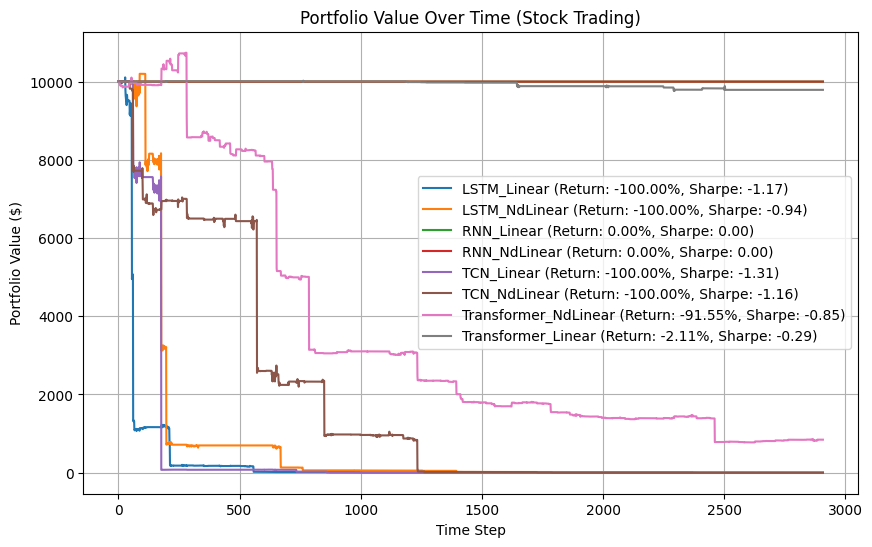

LSTM_Linear: Final Value: $0.03, Total Return: -100.00%, Sharpe Ratio: -1.17
LSTM_NdLinear: Final Value: $0.04, Total Return: -100.00%, Sharpe Ratio: -0.94
RNN_Linear: Final Value: $10000.00, Total Return: 0.00%, Sharpe Ratio: 0.00
RNN_NdLinear: Final Value: $10000.00, Total Return: 0.00%, Sharpe Ratio: 0.00
TCN_Linear: Final Value: $0.00, Total Return: -100.00%, Sharpe Ratio: -1.31
TCN_NdLinear: Final Value: $0.00, Total Return: -100.00%, Sharpe Ratio: -1.16
Transformer_NdLinear: Final Value: $844.75, Total Return: -91.55%, Sharpe Ratio: -0.85
Transformer_Linear: Final Value: $9788.78, Total Return: -2.11%, Sharpe Ratio: -0.29


In [114]:
def simulate_trading(model, dataloader, target_scaler_path="./rawData/target_scaler.pkl", initial_cash=10000, transaction_cost=0.001):
    """
    Simulate trading with scaled allocation for positive predictions and inverse positions for negative predictions.
    For negative predictions, sells long position before buying inverse position. Handles scaled targets by descaling.
    
    Args:
        model: Trained model (LSTM_Linear, LSTM_NdLinear, RNN, TCN, or Transformer_NdLinear)
        dataloader: PyTorch DataLoader with input data [batch_size, timesteps, num_features] and scaled targets [batch_size]
        target_scaler_path: Path to the saved StandardScaler for targets (default: 'target_scaler.pkl')
        initial_cash: Starting capital (default: $10,000)
        transaction_cost: Cost per trade as a fraction (default: 0.1%)
    
    Returns:
        dict: Contains portfolio_values, returns, and sharpe_ratio
    """
    # Load the target scaler
    with open(target_scaler_path, "rb") as f:
        target_scaler = pickle.load(f)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    cash = initial_cash
    position = 0  # Number of units held (positive for long or inverse positions)
    is_inverse = False  # Flag to track if position is inverse
    portfolio_values = [initial_cash]
    returns = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # inputs: [batch_size, timesteps, num_features], targets: [batch_size]
            
            # Get model predictions for the batch
            preds = model(inputs).squeeze()  # Shape: [batch_size]
            
            # Inverse-transform predictions and targets to percent changes
            preds_np = preds.cpu().numpy().reshape(-1, 1)
            targets_np = targets.cpu().numpy().reshape(-1, 1)
            preds_percent = target_scaler.inverse_transform(preds_np).flatten()  # Shape: [batch_size]
            targets_percent = target_scaler.inverse_transform(targets_np).flatten()  # Shape: [batch_size]
            
            # Process each sample in the batch
            for pred, actual_pct in zip(preds_percent, targets_percent):
                # Trading logic
                allocation = 0.0
                if pred >= 1:
                    # Positive predictions: Linear scaling between 1% and 2%
                    abs_pred = abs(pred)
                    if abs_pred >= 2:
                        allocation = 1.0  # 100% allocation for predictions >= 2%
                    else:
                        allocation = 0.5 * (abs_pred - 1) + 0.5  # 1% -> 50%, 2% -> 100%
                    target_is_inverse = False
                elif pred < 0:
                    # Negative predictions: First sell any existing position
                    if position > 0:
                        if is_inverse:
                            # Sell inverse position
                            position_value = position / (1 + actual_pct / 100)  # Inverse position gains when price falls
                            cash += position_value * (1 - transaction_cost)
                        else:
                            # Sell long position
                            cash += position * (1 + actual_pct / 100) * (1 - transaction_cost)
                        position = 0
                        is_inverse = False
                    
                    # Then check for inverse position if prediction is below -0.5%
                    if pred < -0.5:
                        abs_pred = abs(pred)
                        if abs_pred >= 1.5:
                            allocation = 1.0  # 100% allocation for predictions <= -1.5%
                        elif abs_pred >= 0.5:
                            # Linear scaling: -0.5% -> 0%, -1% -> 50%, -1.5% -> 100%
                            allocation = 0.5 * (abs_pred - 0.5) / (1.5 - 0.5)
                        target_is_inverse = True
                    else:
                        target_is_inverse = False
                else:
                    target_is_inverse = False
                
                if pred > 0 and cash > 0 and allocation > 0:
                    # Buy long position: Invest allocation fraction of cash
                    invest_amount = cash * allocation
                    shares_to_buy = invest_amount / (1 + actual_pct / 100) / (1 + transaction_cost)
                    position = shares_to_buy
                    cash -= invest_amount
                    is_inverse = False
                elif pred < -0.5 and cash > 0 and allocation > 0:
                    # Buy inverse position: Invest allocation fraction of cash
                    invest_amount = cash * allocation
                    units_to_buy = invest_amount * (1 + actual_pct / 100) / (1 + transaction_cost)  # Inverse units scale with price
                    position = units_to_buy
                    cash -= invest_amount
                    is_inverse = True
                
                # Update portfolio value
                if is_inverse:
                    # Inverse position: Gains when price falls
                    position_value = position / (1 + actual_pct / 100)
                else:
                    # Long position: Gains when price rises
                    position_value = position * (1 + actual_pct / 100)
                portfolio_value = cash + position_value
                # Prevent negative portfolio value
                portfolio_value = max(0, portfolio_value)
                portfolio_values.append(portfolio_value)
                
                # Calculate daily return
                daily_return = (portfolio_value - portfolio_values[-2]) / portfolio_values[-2]
                returns.append(daily_return)
    
    # Calculate performance metrics
    returns = np.array(returns)
    total_return = (portfolio_values[-1] - initial_cash) / initial_cash
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
    
    return {
        'portfolio_values': portfolio_values,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio
    }

# Example usage with trained models
# Assume lstm_linear, lstm_ndlinear, rnn_linear, rnn_ndlinear, tcn_linear, tcn_ndlinear, model_ndlinear, model_linear are trained
# Use test_loader created from X_test and y_test (scaled targets)
results = {}

# Simulate trading for LSTM_Linear
print("Simulating trading for LSTM_Linear...")
results['LSTM_Linear'] = simulate_trading(lstm_linear.to(device), test_loader)

# Simulate trading for LSTM_NdLinear
print("Simulating trading for LSTM_NdLinear...")
results['LSTM_NdLinear'] = simulate_trading(lstm_ndlinear.to(device), test_loader)

# Simulate trading for RNN_Linear
print("Simulating trading for RNN_Linear...")
results['RNN_Linear'] = simulate_trading(rnn_linear.to(device), test_loader)

# Simulate trading for RNN_NdLinear
print("Simulating trading for RNN_NdLinear...")
results['RNN_NdLinear'] = simulate_trading(rnn_ndlinear.to(device), test_loader)

# Simulate trading for TCN_Linear
print("Simulating trading for TCN_Linear...")
results['TCN_Linear'] = simulate_trading(tcn_linear.to(device), test_loader)

# Simulate trading for TCN_NdLinear
print("Simulating trading for TCN_NdLinear...")
results['TCN_NdLinear'] = simulate_trading(tcn_ndlinear.to(device), test_loader)

# Simulate trading for Transformer_NdLinear
print("Simulating trading for Transformer_NdLinear...")
results['Transformer_NdLinear'] = simulate_trading(model_ndlinear.to(device), test_loader)

# Simulate trading for Transformer_Linear
print("Simulating trading for Transformer_Linear...")
results['Transformer_Linear'] = simulate_trading(model_linear.to(device), test_loader)

# Plot results
plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(res['portfolio_values'], label=f"{name} (Return: {res['total_return']:.2%}, Sharpe: {res['sharpe_ratio']:.2f})")
plt.title("Portfolio Value Over Time (Stock Trading)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.savefig('trading_results.png')
plt.close()
# Print summary
for name, res in results.items():
    print(f"{name}: Final Value: ${res['portfolio_values'][-1]:.2f}, Total Return: {res['total_return']:.2%}, Sharpe Ratio: {res['sharpe_ratio']:.2f}")